In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter # For animation
import pandas as pd
import seaborn as sns
from scipy.spatial import KDTree
from matplotlib import cm
from celluloid import Camera
from IPython.display import HTML

In [5]:
#Define the dimensions of the 2D plate
length = 0.05                                      #Length of the plate
width = 0.05                                       #Width of the plate

#Define the nodes (node)
nx = 10                                           #Number of nodes in x-direction
ny = 10                                            #Number of nodes in y-direction

ndivx = 50
ndivy = 50

dx = length/ndivx 

nbnd = 3

totnode = ndivx * (ndivy + 2 * nbnd)

In [6]:
coord = np.zeros((totnode, 2))

nnum = 0

In [7]:
# Generate internal region points
x_internal = np.linspace(-length / 2 + dx / 2, length / 2 - dx / 2, ndivx)
y_internal = np.linspace(-width / 2 + dx / 2, width / 2 - dx / 2, ndivy)
X_internal, Y_internal = np.meshgrid(x_internal, y_internal)
internal_points = np.column_stack((X_internal.ravel(), Y_internal.ravel()))

# Generate boundary region points (bottom and top)
x_boundary = np.linspace(-length / 2 + dx / 2, length / 2 - dx / 2, ndivx)
y_bottom = np.linspace(-width / 2 - dx / 2, -width / 2 - nbnd * dx + dx / 2, nbnd)
y_top = np.linspace(width / 2 + dx / 2, width / 2 + nbnd * dx - dx / 2, nbnd)

X_bottom, Y_bottom = np.meshgrid(x_boundary, y_bottom)
X_top, Y_top = np.meshgrid(x_boundary, y_top)

bottom_points = np.column_stack((X_bottom.ravel(), Y_bottom.ravel()))
top_points = np.column_stack((X_top.ravel(), Y_top.ravel()))

# Combine all points
coord = np.vstack((internal_points, bottom_points, top_points))

In [8]:
delta = 3.015 * dx

totint = len(internal_points)

totbottom = totint + len(bottom_points)

tottop = totbottom + len(top_points)

#initialization of fail flag array
maxfam = 100 #Max number of material points inside the horizon of the material point

fail = np.ones((totnode, maxfam), dtype=int)

In [9]:
# Arrays to track the family members
pointfam = np.zeros(totnode, dtype=int)
numfam = np.zeros(totnode, dtype=int)
nodefam = np.zeros(1000000, dtype=int)

#Calculate pairwise distances using broadcasting
dist_matrix = np.sqrt(np.sum((coord[:, np.newaxis, :] - coord[np.newaxis, :, :]) ** 2, axis = 2))

#Set diagonal to infinity to avoid self-selection
np.fill_diagonal(dist_matrix, np.inf)

#Identify family members for each material point
within_horizon = dist_matrix <= delta

#Fill 'numfam', 'nodefam', and 'pointfam' arrays
current_index = 0 #Track the current position in nodefam

for i in range(totnode):
    family_members = np.where(within_horizon[i])[0]  # Get family members' indices
    num_members = len(family_members)  # Number of family members

    # Store the number of family members
    numfam[i] = num_members

    # Update the `pointfam` array
    pointfam[i] = current_index

    # Store family member indices in `nodefam`
    nodefam[current_index:current_index + num_members] = family_members

    # Move the current index forward
    current_index += num_members

# Trim unused space in `nodefam` for efficiency
nodefam = nodefam[:current_index]

In [10]:
# Definition of the crack surface
crlength = 0.01  # Crack length

# Flattened coordinates for easier vectorized operations
x_coords = coord[:, 0]
y_coords = coord[:, 1]

# Create a boolean mask to identify if a bond penetrates the crack
def bond_penetrates_crack(i, cnode):
    return (
        (y_coords[cnode] > 0.0 and y_coords[i] < 0.0) or 
        (y_coords[i] > 0.0 and y_coords[cnode] < 0.0)
    )

def is_crack_position(x):
    return abs(x) <= crlength / 2.0 + 1.0e-10

# Loop through nodes and their families
for i in range(totnode):
    for j in range(numfam[i]):
        cnode = nodefam[pointfam[i] + j]

        # Check if the bond penetrates the crack surface
        if bond_penetrates_crack(i, cnode):
            if is_crack_position(x_coords[i]) or is_crack_position(x_coords[cnode]):
                fail[i, j] = 0

# Verify the result
print("Fail array updated successfully.")

Fail array updated successfully.


In [11]:
radij = dx / 2.0  # Material point radius
area = dx * dx  # Cross-sectional area
vol = area * dx  # Volume of a material point
thick = dx  # Total thickness of the plate

dens = 8000.0  # Density of the material
emod = 192.0e9  # Elastic modulus
bc = 9.0 * emod / (np.pi * thick * (delta ** 3))  # Bond constant

# Initialize displacement array
disp = np.zeros((totnode, 2))  # Displacement of a material point

In [12]:
# Initialization of displacements and velocities
vel = np.zeros((totnode, 2))  # Velocity of material points
disp = np.zeros((totnode, 2))  # Displacement of material points

# Stable mass vector computation
dt = 0.8 * np.sqrt(2.0 * dens * dx / (np.pi * delta**2 * dx * bc))
# dt: Time interval

In [13]:
dt

1.3366625103842283e-07

In [12]:
# Applied loading - Left and Right
appres = 200.0e6  # Applied pressure

# Initialize body load, acceleration, and forces
bforce = np.zeros((totnode, 2))  # Body load on each material point

# Time integration parameters
nt = 1250  # Total number of time steps
alpha = 23.0e-6  # Coefficient of thermal expansion
dtemp = 0.0  # Temperature change
pratio = 1.0 / 3.0  # Poisson's ratio
scr0 = 1.0  # Critical stretch

# Initialize arrays for forces, displacements, and velocity
dmg = np.zeros((totint, 1))  # Damage array

pforce = np.zeros((totnode, 2))  # Peridynamic force on each material point
pforceold = np.zeros((totnode, 2))  # Peridynamic force at previous time step

acc = np.zeros((totnode, 2))  # Acceleration of material points

velhalf = np.zeros((totnode, 2))  # Half-step velocity
velhalfold = np.zeros((totnode, 2))  # Half-step velocity from previous step

# Displacement arrays for specific time steps
coord_disp_pd_750_pwc = np.zeros((totint, 4))  # Time step 750
coord_disp_pd_1000_pwc = np.zeros((totint, 4))  # Time step 1000
coord_disp_pd_1250_pwc = np.zeros((totint, 4))  # Time step 1250

# Array to monitor steady-state convergence
steady_check = np.zeros((nt, 3))  # Track steady-state values over time

# Initialize constants
cn = 0.0
cn1 = 0.0
cn2 = 0.0


In [14]:
# Time integration
import numpy as np

nt = 1250  # Total number of time steps
alpha = 23.0e-6  # Coefficient of thermal expansion
dtemp = 0.0  # Temperature change
pratio = 1.0 / 3.0  # Poisson's ratio
scr0 = 1.0  # Critical stretch

dmg = np.zeros(totint)

pforce = np.zeros((totnode, 2))  # total peridynamic force acting on a material point
pforceold = np.zeros((totnode, 2))  # total peridynamic force acting on a material point in the previous time step
acc = np.zeros((totnode, 2))  # acceleration of a material point

velhalf = np.zeros((totnode, 2))
velhalfold = np.zeros((totnode, 2))

coord_disp_pd_all_pwc = np.zeros((nt, totint, 4))  # Peridynamic displacement and Analytical displacement of all points at all time steps

steady_check = np.zeros((nt, 3))

cn = 0.0
cn1 = 0.0
cn2 = 0.0

for tt in range(1, nt + 1):
    print(f"{tt}/{nt}")
    ctime = tt * dt

    # Application of boundary conditions at the top and bottom edges
    vel[totint:totbottom, 1] = -20.0
    disp[totint:totbottom, 1] = -20.0 * tt * dt

    vel[totbottom:tottop, 1] = 20.0
    disp[totbottom:tottop, 1] = 20.0 * tt * dt

    dmgpar1 = np.zeros(totint)
    dmgpar2 = np.zeros(totint)
    pforce[:, :] = 0.0

    for i in range(totint):
        cnode_start = pointfam[i]
        cnode_end = cnode_start + numfam[i]
        cnode_indices = nodefam[cnode_start:cnode_end]
        ccoords = coord[cnode_indices]
        cdisps = disp[cnode_indices]
        idists = np.sqrt((ccoords[:, 0] - coord[i, 0]) ** 2 + (ccoords[:, 1] - coord[i, 1]) ** 2)
        nlengths = np.sqrt((ccoords[:, 0] + cdisps[:, 0] - coord[i, 0] - disp[i, 0]) ** 2 + (ccoords[:, 1] + cdisps[:, 1] - coord[i, 1] - disp[i, 1]) ** 2)

        fail_mask = fail[i, :numfam[i]] == 1
        dforce1 = np.where(fail_mask, bc * (nlengths - idists) / idists * vol * (ccoords[:, 0] + cdisps[:, 0] - coord[i, 0] - disp[i, 0]) / nlengths, 0.0)
        dforce2 = np.where(fail_mask, bc * (nlengths - idists) / idists * vol * (ccoords[:, 1] + cdisps[:, 1] - coord[i, 1] - disp[i, 1]) / nlengths, 0.0)

        pforce[i, 0] += np.sum(dforce1)
        pforce[i, 1] += np.sum(dforce2)

        no_fail_zone = (np.abs((nlengths - idists) / idists) > scr0) & (np.abs(coord[i, 1]) <= (length / 4.0))
        fail[i, :numfam[i]] = np.where(no_fail_zone, 0, fail[i, :numfam[i]])

        dmgpar1[i] = np.sum(fail[i, :numfam[i]] * vol)
        dmgpar2[i] = np.sum(vol)

    dmg = 1.0 - dmgpar1 / dmgpar2

    acc = (pforce + bforce) / dens
    vel[:totint] += acc[:totint] * dt
    disp[:totint] += vel[:totint] * dt

    acc[totint:totbottom, 0] = (pforce[totint:totbottom, 0] + bforce[totint:totbottom, 0]) / dens
    vel[totint:totbottom, 0] += acc[totint:totbottom, 0] * dt
    disp[totint:totbottom, 0] += vel[totint:totbottom, 0] * dt

    acc[totbottom:tottop, 0] = (pforce[totbottom:tottop, 0] + bforce[totbottom:tottop, 0]) / dens
    vel[totbottom:tottop, 0] += acc[totbottom:tottop, 0] * dt
    disp[totbottom:tottop, 0] += vel[totbottom:tottop, 0] * dt

    coord_disp_pd_all_pwc[tt - 1, :, :4] = np.hstack((coord[:totint], disp[:totint]))

    steady_check[tt - 1, :3] = [tt, disp[1080-1, 0], disp[1080-1, 1]]


1/1250
2/1250
3/1250
4/1250
5/1250
6/1250
7/1250
8/1250
9/1250
10/1250
11/1250
12/1250
13/1250
14/1250
15/1250
16/1250
17/1250
18/1250
19/1250
20/1250
21/1250
22/1250
23/1250
24/1250
25/1250
26/1250
27/1250
28/1250
29/1250
30/1250
31/1250
32/1250
33/1250
34/1250
35/1250
36/1250
37/1250
38/1250
39/1250
40/1250
41/1250
42/1250
43/1250
44/1250
45/1250
46/1250
47/1250
48/1250
49/1250
50/1250
51/1250
52/1250
53/1250
54/1250
55/1250
56/1250
57/1250
58/1250
59/1250
60/1250
61/1250
62/1250
63/1250
64/1250
65/1250
66/1250
67/1250
68/1250
69/1250
70/1250
71/1250
72/1250
73/1250
74/1250
75/1250
76/1250
77/1250
78/1250
79/1250
80/1250
81/1250
82/1250
83/1250
84/1250
85/1250
86/1250
87/1250
88/1250
89/1250
90/1250
91/1250
92/1250
93/1250
94/1250
95/1250
96/1250
97/1250
98/1250
99/1250
100/1250
101/1250
102/1250
103/1250
104/1250
105/1250
106/1250
107/1250
108/1250
109/1250
110/1250
111/1250
112/1250
113/1250
114/1250
115/1250
116/1250
117/1250
118/1250
119/1250
120/1250
121/1250
122/1250
123/1250
1

<Figure size 432x288 with 0 Axes>

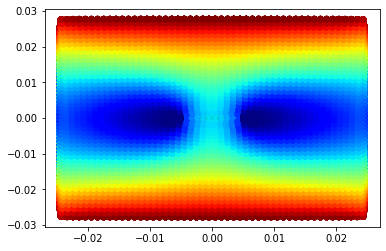

In [23]:
camera = Camera(plt.figure())
fig, ax = plt.subplots()
for current_time_step in range(nt):
    scatter = ax.scatter(
        coord_disp_pd_all_pwc[current_time_step, :, 0] + coord_disp_pd_all_pwc[current_time_step, :, 2],
        coord_disp_pd_all_pwc[current_time_step, :, 1] + coord_disp_pd_all_pwc[current_time_step, :, 3],
        c=np.sqrt(coord_disp_pd_all_pwc[current_time_step, :, 2]**2 + coord_disp_pd_all_pwc[current_time_step, :, 3]**2),
        cmap='jet'
    )
    camera.snap()

In [14]:
# After the loop, use the captured frames from the camera object to create the animation
anim = camera.animate(blit=True)

NameError: name 'camera' is not defined

In [15]:
# Save the animation as a GIF using PillowWriter
anim.save('scatter_plot_animation15.gif', writer='pillow')

# Display the GIF inline in the notebook
HTML('<img src="scatter_plot_animation15.gif">')

NameError: name 'anim' is not defined